In [66]:
import csv
import os

import numpy as np
import pandas as pd
#from owid_downloader import GenerateTrainingData
#from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from stan_sirvc_layer import run_layer, get_features
import matplotlib.dates as mdates

In [67]:
#GenerateTrainingData().download_jhu_data('2020-08-01', '2020-12-01')
start_date = '2021-01-01'
end_date = '2021-05-31'

In [68]:
# data processing
raw_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', usecols=["location", "date", "total_cases", "new_cases_smoothed", "total_deaths",
                    "new_deaths", "total_vaccinations", "people_fully_vaccinated", "new_vaccinations", "population"])
raw_data['date'] = pd.to_datetime(raw_data['date'])
mask = (raw_data['date'] >= start_date) & (raw_data['date'] <= end_date)
raw_data = raw_data.loc[mask]

countries = []
loc_list = list(raw_data['location'].unique())
# only include countries that have more than 1000 total cases on start date and at least 1 death
for loc in loc_list:
    if raw_data[raw_data['location'] == loc]["total_cases"].values[0] > 1000 and \
        raw_data[raw_data['location'] == loc]["total_deaths"].values[0] > 0:
        countries.append(loc)
# hard-coded; these are problematic locations (non-countries) that need to be removed
countries.remove("European Union")
countries.remove("Europe")
countries.remove("Africa")
countries.remove("Asia")
countries.remove("North America")
countries.remove("Oceania")
countries.remove("South America")
countries.remove("World")
countries.remove("Tajikistan")
continents = ["Europe", "Africa", "Asia", "North America", "South America", "Oceania"]
world = ["World"]

country_mask = raw_data['location'].isin(countries)
continent_mask = raw_data['location'].isin(continents)
world_mask = raw_data['location'].isin(world)

country_raw_data = raw_data.loc[country_mask]
continent_raw_data = raw_data.loc[continent_mask]
world_raw_data = raw_data.loc[world_mask]

print(len(country_raw_data['location'].unique()))   # 163
print(len(continent_raw_data['location'].unique())) # 6
print(len(world_raw_data['location'].unique()))     # 1

163
6
1


In [69]:
# layer 1, 2, 3
test_window = 29
history_window=14 # days of information
pred_window=14 # predicts future # of days
test_start_date = pd.to_datetime(end_date) + pd.DateOffset(days=-test_window)
_, world_features, world_active_cases, world_static_feat, world_norms = get_features(world_raw_data, start_date, end_date, world, edges=False)

done


In [70]:
loc_name = "World"
continent_pred_prev = []
continent_pred_test = []
random = False
for continent in continents:
    if not random:
        continent_pred_prev.append(pickle.load(open(f'results/trained_{continent}_pred_dI_prev', 'rb')))
        continent_pred_test.append(pickle.load(open(f'results/trained_{continent}_pred_dI', 'rb')))
    if random:
        continent_pred_prev.append(pickle.load(open(f'results/trained_{continent}_pred_dI_prev_random', 'rb')))
        continent_pred_test.append(pickle.load(open(f'results/trained_{continent}_pred_dI_random', 'rb')))

continent_pred_prev = np.array(continent_pred_prev)
continent_pred_test = np.array(continent_pred_test)

input_continent_pred_prev = (continent_pred_prev - world_norms[0][0]) / world_norms[1][0]
input_continent_pred_test = (continent_pred_test - world_norms[0][0]) / world_norms[1][0]

In [71]:
print(continent_pred_prev.shape) # n_loc, timestep, pred_window

x_train = input_continent_pred_prev.transpose(1, 0, 2) # swap locs with timesteps
x_test = input_continent_pred_test.transpose(1, 0, 2)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]) # timesteps, locs*pred_window
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

print(x_train.shape)

# get true_dI for each continent
true_dI_train = world_features[0][5] # 0=train, 5=yI; locations, timesteps, values
true_dI_val = world_features[1][5]

# target for train and test
true_dI_prev = np.concatenate((true_dI_train, true_dI_val), axis=1)
true_dI_test = world_features[2][5]

y_train = true_dI_prev[0]
y_test = true_dI_test[0]

(6, 19, 14)
(19, 84)


In [72]:
class MLP(nn.Module):
    def __init__(self, n_continents, pred_window):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_continents*pred_window, 64),
            nn.ReLU(),
            nn.Linear(64, pred_window)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(x_train, dtype=torch.float).to(device)
x_test = torch.tensor(x_test, dtype=torch.float).to(device)

y_train = torch.tensor(y_train, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

model = MLP(len(continents), pred_window).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(2000):
    model.train()

    optimizer.zero_grad()
    train_pred = model(x_train)
    loss = loss_fn(train_pred, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))

MLP(
  (layers): Sequential(
    (0): Linear(in_features=84, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=14, bias=True)
  )
)
Epoch 0: train loss: 0.6462457776069641
Epoch 10: train loss: 0.5104310512542725
Epoch 20: train loss: 0.3557394742965698
Epoch 30: train loss: 0.20883233845233917
Epoch 40: train loss: 0.1203899011015892
Epoch 50: train loss: 0.08025120198726654
Epoch 60: train loss: 0.0683147981762886
Epoch 70: train loss: 0.060771435499191284
Epoch 80: train loss: 0.05626152455806732
Epoch 90: train loss: 0.05363292619585991
Epoch 100: train loss: 0.05123676359653473
Epoch 110: train loss: 0.04928186908364296
Epoch 120: train loss: 0.04753967374563217
Epoch 130: train loss: 0.045754991471767426
Epoch 140: train loss: 0.043975263833999634
Epoch 150: train loss: 0.042244065552949905
Epoch 160: train loss: 0.040511004626750946
Epoch 170: train loss: 0.038788117468357086
Epoch 180: train loss: 0.037102844566106796
Epoch 190: train loss

In [74]:
test_pred = model(x_test)

# Cumulate predicted dI
pred_I = (test_pred.detach().cpu().numpy() * world_norms[1][0]) + world_norms[0][0]
pred_I_prev = (train_pred.detach().cpu().numpy() * world_norms[1][0]) + world_norms[0][0]
# pickle.dump(pred_I, open(f"./results/trained_{continent}_pred_dI", 'wb'), 2)
# pickle.dump(pred_I_prev, open(f"./results/trained_{continent}_pred_dI_prev", 'wb'), 2)
pred_I = np.cumsum(pred_I)

test_I = world_features[2][1]

pred_I = pred_I + test_I[0]
print(pred_I)

pred_I = np.array(pred_I)

[10150457. 10016774.  9908096.  9867610.  9759169.  9628968.  9572678.
  9417512.  9226887.  9178077.  9034421.  8908541.  8705593.  8596234.]


In [75]:
I_true = world_active_cases[0][-test_window:]
I_true = I_true[history_window:history_window+pred_window]
print(I_true)

[10058856.  9873921.  9704407.  9113707.  8906597.  8698972.  8533923.
  8367378.  8160793.  7969293.  7799285.  7581473.  7434742.  7277611.]


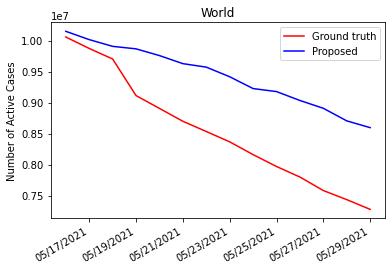

In [76]:
import matplotlib.dates as mdates
dates = [test_start_date + pd.DateOffset(days=i+history_window) for i in range(pred_window)]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.plot(dates, I_true, c='r', label='Ground truth')
plt.plot(dates, pred_I, c='b', label='Proposed')
# stan_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_new", "rb"))
# stan_sirv_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_sirv", "rb"))
# plt.plot(dates, stan_res[-1, :], c='g', label="STAN (SIRV)")
# plt.plot(dates, sir_I[-1, :], c='purple', label="SIRVIC")
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel("Number of Active Cases")
plt.title("World")
plt.show()

In [77]:
prop_mse = ((pred_I - I_true)**2).mean()
print(f"Proposed: {prop_mse}")

Proposed: 975031148504.5


In [79]:
for true in I_true:
    print(true)

10058856.0
9873921.0
9704407.0
9113707.0
8906597.0
8698972.0
8533923.0
8367378.0
8160793.0
7969293.0
7799285.0
7581473.0
7434742.0
7277611.0
